# Counterfactual : the Effect of Education and Experience on Salary

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

This notebook follows the example from "The Book Of Why" (Pearl, 2018) chapter 8 page 251. 

## Counterfactuals

In [1]:
from IPython.display import display, Math, Latex,HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import math
import numpy as np
import scipy.stats



In this example we are interested in the effect of experience and education on the salary of an employee, we are in possession of the following data:


<table>
    <tr>
        <th>Employé</th> <th>EX(u)</th> <th>ED(u)</th> <th> $S_{0}(u)$</th> <th> $S_{1}(u)$</th> <th>$S_{2}(u)$</th>
    </tr>
    <tr>
        <td>Alice</td> <td>8</td> <td>0</td> <td>86,000</td> <td>?</td> <td>?</td> 
    </tr>
    <tr>
        <td>Bert</td> <td>9</td> <td>1</td> <td>?</td> <td>92,500</td> <td>?</td> 
    </tr>
    <tr>
        <td>Caroline</td> <td>9</td> <td>2</td> <td>?</td> <td>?</td> <td>97,000</td> 
    </tr>
    <tr>
        <td>David</td> <td>8</td> <td>1</td> <td>?</td> <td>91,000</td> <td>?</td>
    </tr>
    <tr>
        <td>Ernest</td> <td>12</td> <td>1</td> <td>?</td> <td>100,000</td> <td>?</td> 
    </tr>
    <tr>
        <td>Frances</td> <td>13</td> <td>0</td> <td>97,000</td> <td>?</td> <td>?</td> 
    </tr>
    <tr>
        <td>etc</td> <td> </td> <td> </td> <td> </td> <td> </td> <td> </td> 
    </tr>
</table>


* $EX(u)$ : years of experience of employee $u$. [0,20]
* $ED(u)$ : Level of education of employee $u$ (0:high school degree (low), 1:college degree (medium), 2:graduate degree (high)) [0,2]
* $S_{i}(u)$ [65k,150k] :
   * salary (observable) of employee $u$ if $i = ED(u)$, 
   * Potential outcome (unobservable) if $i \not = ED(u)$, salary of employee $u$ if he had a level of education of $i$.  

> We are left with the previous data and we want to answer the counterfactual question <b> What would Alice's salary be if she attended college ? </b>(i.e. $S_{1}(Alice)$)

### We create the causal diagram

> In this model it is assumed that an employee's salary is determined by his level of education and his experience. Years of experience are also affected by the level of education. Having a higher level of education means spending more time studying hence less experience.

In [2]:
edex = gum.fastBN("Ux[-2,10]->experience[0,20]<-education[0,2]->salary[65,150];"
                  "experience->salary<-Us[0,25]")
edex

(pyAgrum.BayesNet<double>@0x382009c00) BN{nodes: 5, arcs: 5, domainSize: 10^6.26276, dim: 140049, mem: 1Mo 83Ko 264o}

However counterfactual queries are specific  to one datapoint (in our case Alice), we need to add additional variables to our model to allow for individual variations:
* Us : unobserved variables that affect salary.[0,25k]
* Ux : unobserved variables that affect experience.[-2,10]

In [24]:
# no prior information about the individual (datapoint)
edex.cpt("Us").fillWith(1).normalize()
edex.cpt("Ux").fillWith(1).normalize()
# education level(supposed)
edex.cpt("education")[:] = [0.4, 0.4, 0.2]

In [25]:
# To have probabilistic results, we add a perturbation. (Gaussian around the exact values)
# we calculate a gaussian distribution 

std = 1


Experience listens to Education and Ux :
$$Ex = 10 -4 \times Ed + Ux$$

In [26]:
edex.cpt("experience").fillFromDistribution(scipy.stats.norm,loc="10-4*education+Ux",scale=std)
edex.cpt("experience")

(pyAgrum.Potential<double>@0x600001170f40) 
             ||  experience                                                                                                                                                                                                     |
Ux    |educat||0        |1        |2        |3        |4        |5        |6        |7        |8        |9        |10       |11       |12       |13       |14       |15       |16       |17       |18       |19       |20       |
------|------||---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
-2    |0     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
-1    |0     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
0     |0     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
1     |0     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
2     |0     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
3     |0     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  |
[...27 more line(s) ...]
5     |2     || 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
6     |2     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
7     |2     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
8     |2     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
9     |2     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
10    |2     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0001  | 0.0044  | 0.0540  | 0.2420  | 0.3989  | 0.2420  | 0.0540  | 0.0044  | 0.0001  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |

Salary listens to Education, Experience and Us :
$$S = 65 + 2.5 \times Ex + 5 \times Ed + Us$$

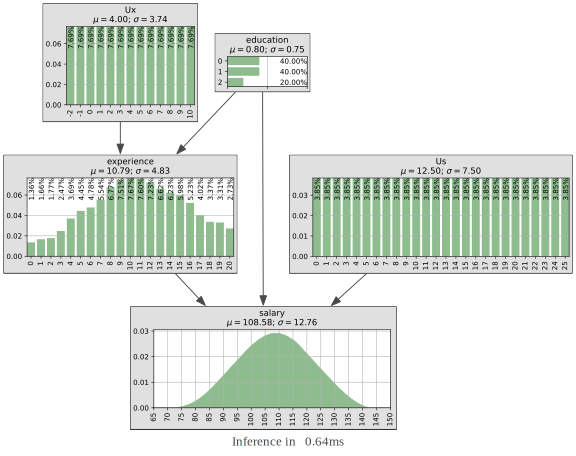

In [27]:
edex.cpt("salary").fillFromDistribution(scipy.stats.norm,loc="65+2.51*experience+5*education+Us",scale=std)
gnb.showInference(edex)

To answer this counterfactual question we will follow the three steps algorithm from "The Book Of Why" (Pearl 2018) chapter 8 page 253 :

## Step 1 : Abduction
Use the data to retrieve all the information that characterizes Alice 

From the data we can retrieve Alice's profile : 
* $Ed(Alice)$ : 0
* $Ex(Alice)$ : 8
* $S_{0}(Alice)$ : 86k 

We will use Alice's profile to get $U_s$ and $U_x$, which tell Alice apart from the rest of the data.

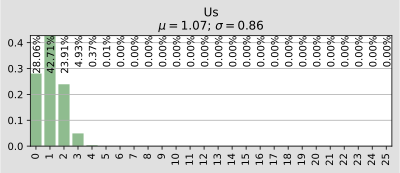

In [40]:
ie=gum.LazyPropagation(edex)
ie.setEvidence({'education': 0, 'salary' : "86", "experience":8})
ie.makeInference()
newUs = ie.posterior("Us")
gnb.showProba(newUs)

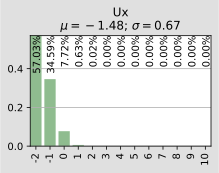

In [41]:
ie=gum.LazyPropagation(edex)
ie.setEvidence({'education': 0, 'salary' : "86", "experience":8})
ie.makeInference()
newUx = ie.posterior("Ux")
gnb.showProba(newUx)

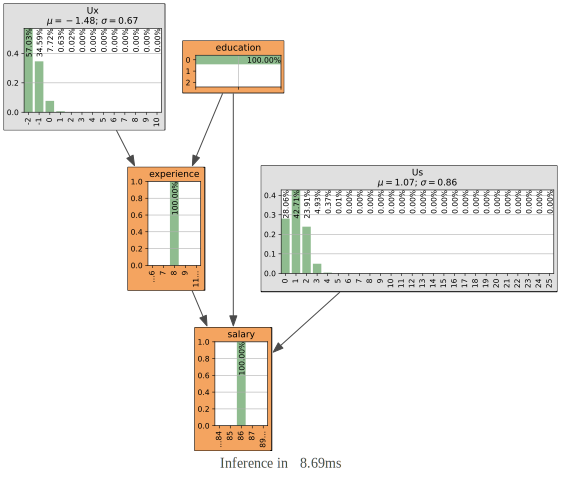

In [42]:
gnb.showInference(edex,evs={'education': 0, 'salary' : "86", "experience":8})

## Step 2 & 3 : Action And Prediction
Change the model to match the hypothesis implied by the query (if she had attended university) and then use the data that characterizes Alice to calculate her salary.

We create a counterfactual world with Alice's idiosyncratic factors, and we operate the intervention:

In [43]:
# the counterfactual world
edexCounterfactual = gum.BayesNet(edex)

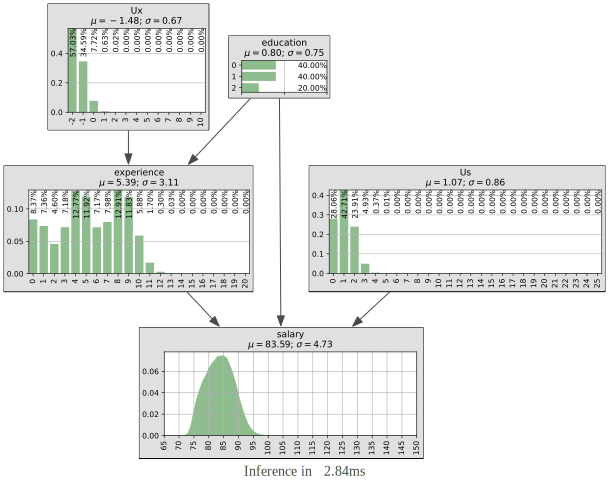

counterfactual world created


In [44]:
# we replace the prior probabilities of idiosynatric factors with potentials calculated earlier
edexCounterfactual.cpt("Ux").fillWith(newUx)
edexCounterfactual.cpt("Us").fillWith(newUs)
gnb.showInference(edexCounterfactual,size="10")
print("counterfactual world created")


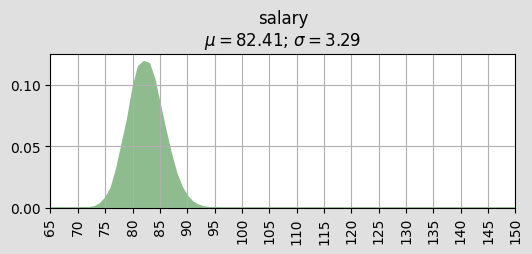

In [46]:
# We operate the intervention
edexModele = csl.CausalModel(edexCounterfactual)
cslnb.showCausalImpact(edexModele,"salary",
                       doing="education",
                       values={"education":"1"})

>In the previous query, Alice's salary if she attended college was lower than her actual salary, that's because in the counterfactual world where she attended college she had less time to work hence her diminished salary.

We can prove it perfoming a complete inference in the counterfactual world. Since education has no parents in our model (no graph surgery, no causes to emancipate it from), an intervention is equivalent to an observation, the only thing we need to do is to set the value of education:

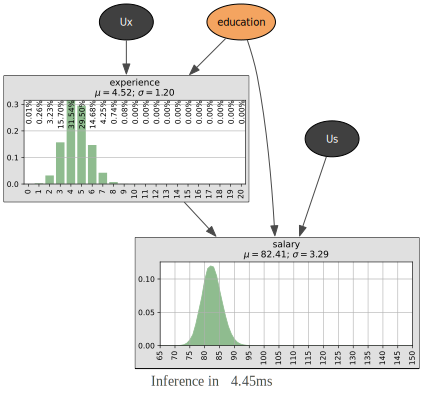

In [59]:
gnb.showInference(edexCounterfactual,targets={"salary",'experience'},evs={'education':"1"},size="10")

Indeed the expected "experience" decreased. 

The result (salary if she had attended college) is given by the formaula: $$\sum_{salary} salary \times P(salary^* \mid RealSalary = 86k, education = 0, experience = 8, education^*=1)$$
Where variables marked with an asterisk are inobservable.

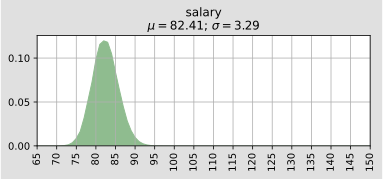

In [60]:
formula, adj, exp = csl.causalImpact(edexModele,"salary",
                                     doing="education",
                                     values={"education":"1"})
gnb.showProba(adj)

In [61]:
salary=edexModele.observationalBN()["salary"]
adj.expectedValue(lambda v : salary.numerical(v["salary"]))

82.4140879489839

### $$S_1(Alice) = 82k $$  Alice's salary would be $\$82.4$ if she had attended college !

## `pyAgrum.causal.counterfactual`
We can now use a function that answers counterfactual queries using the previous algorithm.

In [62]:
help(csl.counterfactual)

Help on function counterfactual in module pyAgrum.causal._causalImpact:

counterfactual(cm: pyAgrum.causal._CausalModel.CausalModel, profile: Optional[Dict[str, int]], on: Union[str, Set[str]], whatif: Union[str, Set[str]], values: Optional[Dict[str, int]] = None) -> 'pyAgrum.Potential'
    Determines the estimation of a counterfactual query following the the three steps algorithm from "The Book Of Why"
    (Pearl 2018) chapter 8 page 253.

    Determines the estimation of the counterfactual query: Given the "profile" (dictionary <variable name>:<value>),what
    would variables in "on" (single or list of variables) be if variables in "whatif" (single or list of variables) had
    been as specified in "values" (dictionary <variable name>:<value>)(optional).

    This is done according to the following algorithm:
        -Step 1-2: compute the twin causal model
        -Step 3 : determine the causal impact of the interventions specified in  "whatif" on the single or list of
        vari

### Let's try with the previous query :

In [63]:
cm_edex= csl.CausalModel(edex)
pot=csl.counterfactual(cm =cm_edex, 
                       profile = {'education': 0, 'experience':8, 'salary' : "86"},
                       whatif={"education"},
                       on={"salary"}, 
                       values = {"education" : 1})

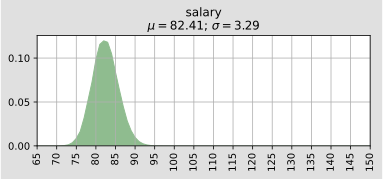

In [64]:
gnb.showProba(pot)

We get the same result !

### If we omit values:

We get every potential outcome :

In [65]:
pot=csl.counterfactual(cm =cm_edex, 
                       profile = {'experience':8, 'education': '0', 'salary' : '86'},
                       whatif={"education"},
                       on={"salary"})

In [66]:
gnb.showPotential(pot)

### What would Alice's salary be if she had attended college and had 8 years of experience ?

In [67]:
pot=csl.counterfactual(cm =cm_edex, 
                       profile = {'experience':8, 'education': 0, 'salary' : '86'},
                       whatif={"education", "experience"},
                       on={"salary"}, 
                       values = {"education" : 1, "experience" : 8})

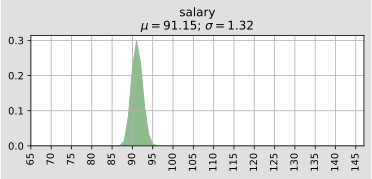

In [68]:
gnb.showProba(pot)

### if she attended college and had 8 years of experience Alice's salary would be 91k !

>In the previous query, Alice's salary if she attended college was lower than her actual salary, that's because in the counterfactual world where she attended college she had less time to work hence her diminished salary. 

>In this query, Alice's counterfactual salary was higher than her actual salary (+5k corresponding to one level of education), that's because in the counterfactual world Alice attended college and still had time to work 8 years, so her salary went up. 

### if she had more experience :
of course, her salary goes up.

In [70]:
pot=csl.counterfactual(cm =cm_edex, 
                       profile = {'experience':8, 'education': 0, 'salary' : '86'},
                       whatif={"experience"},
                       on={"salary"}, 
                       values = {"experience" : 10})
pot

(pyAgrum.Potential<double>@0x600001152d80) 
  salary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
65       |66       |67       |68       |69       |70       |71       |72       |73       |74       |75       |76       |77       |78       |79       |80       |81       |82       |83       |84       |85       |86       |87       |88       |89       |90       |91       |92       |93       |94       |95       |96       |97       |98       |99       |100      |101      |102      |103      |104      |105      |106      |107      |108      |109      |110      |111      |112      |113      |114      |115      |116      |117      |118      |119      |120      |121      |122      |123      |124      |125      |126      |127      |128      |129      |130      |131      |132      |133      |134      |135      |136      |137      |138      |139      |140      |141      |142      |143      |144      |145      |146      |147      |148      |149      |150      |
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
 nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     | nan     |

In [71]:
twin=csl.counterfactualModel(cm = csl.CausalModel(edex), 
                       profile = {'experience':8, 'education': 0, 'salary' : '86'},
                       whatif={"experience"})
gnb.sideBySide(twin,gnb.getInference(twin.observationalBN(),size="10"))

G <!-- Ux --> Ux Ux <!-- experience --> experience experience <!-- Ux->experience --> Ux->experience <!-- salary --> salary salary <!-- experience->salary --> experience->salary <!-- education --> education education <!-- education->experience --> education->experience <!-- education->salary --> education->salary <!-- Us --> Us Us <!-- Us->salary --> Us->salary


In [72]:
edexModeleWithout = csl.CausalModel(edex) #(<latent variable name>, <list of affected variables’ ids>).
edexModeleWithout

### Let's try with the other queries :

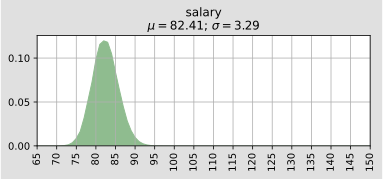

In [73]:
pot = csl.counterfactual(cm = edexModeleWithout, 
                         profile = {'experience':8, 'education': 0, 'salary' : "86"},
                         whatif={"education"},
                         on={"salary"}, 
                         values = {"education" : 1})
gnb.showProba(pot)

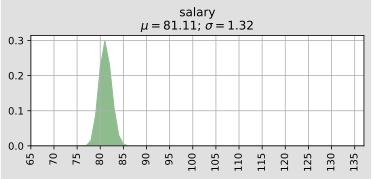

In [74]:
pot=csl.counterfactual(cm = edexModeleWithout, 
                       profile = {'experience':8, 'education': 0, 'salary' : '86'},
                       whatif={"education", "experience"},
                       on={"salary"}, 
                       values = {"education" : 1, "experience" : 4})
gnb.showProba(pot)

### Latent variable between $U_x$ and $experience$ :

In [ ]:
edexModeleWithOne = csl.CausalModel(edex,[("u1", ["Ux","experience"])],False) #(<latent variable name>, <list of affected variables’ ids>).
edexModeleWithOne

In [ ]:
pot = csl.counterfactual(cm = edexModeleWithOne, 
                         profile = {'experience':8, 'education': 0, 'salary' : "86"},
                         whatif={"education"},
                         on={"salary"}, 
                         values = {"education" : 1})
gnb.showProba(pot)

> With one latent variable between $U_x$ and $experience$, we get \$96k corresponding to one education level (we don't need to worry about experience any more.)

In [ ]:
pot = csl.counterfactual(cm = edexModeleWithOne, 
                         profile = {'experience':8, 'education': 0, 'salary' : "86"},
                         whatif={"education"},
                         on={"salary"}, 
                         values = {"education" : 2})
gnb.showProba(pot)